# Customer Lifetime Value Analysis

The marketing team wants to determine how much they can spend on acquiring new customers to the platform. To achieve this, they need a CLV analysis for all customers, covering their entire relationship duration with the company.

In [18]:
from resq_pipeline.data_pipeline import DataPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline
plt.style.use("seaborn-v0_8-talk")
#plt.style.available

## Initialize Data pipeline

In [19]:
pipeline = DataPipeline()

12:23:03 Initializing pipeline
12:23:03 Creating customer cohorts view in database
12:23:03 Creating top partners by sales view in database
12:23:03 Creating partner segments and order quantity view in database
12:23:03 Creating Lifespan, Frequency, sales value view in database
12:23:03 Done


## Retention Rate Analysis

In [20]:
query = """ 
            SELECT 
                MONTHS_SINCE_FIRST_PURCHASE AS M,
                (CAST( COUNT(MONTHS_SINCE_FIRST_PURCHASE) AS REAL) / 
                CAST((SELECT COUNT(DISTINCT(USERID)) FROM CUSTOMER_COHORT) AS REAL))*100 AS RETENTION_RATE,
                COUNT(MONTHS_SINCE_FIRST_PURCHASE) as CUSTOMER_COUNT
            FROM CUSTOMER_COHORT
            GROUP BY MONTHS_SINCE_FIRST_PURCHASE
        """
retention_rate = pipeline.execute_query(query=query)

In [21]:
retention_rate

,M,RETENTION_RATE,CUSTOMER_COUNT
0,0,100.000000,123208
1,1,14.587527,17973
2,2,12.001656,14787
3,3,10.594280,13053
4,4,9.544835,11760
5,5,8.895526,10960
6,6,7.850140,9672
7,7,7.306344,9002
8,8,6.209012,7650
9,9,5.468801,6738


### Ploting retention curve

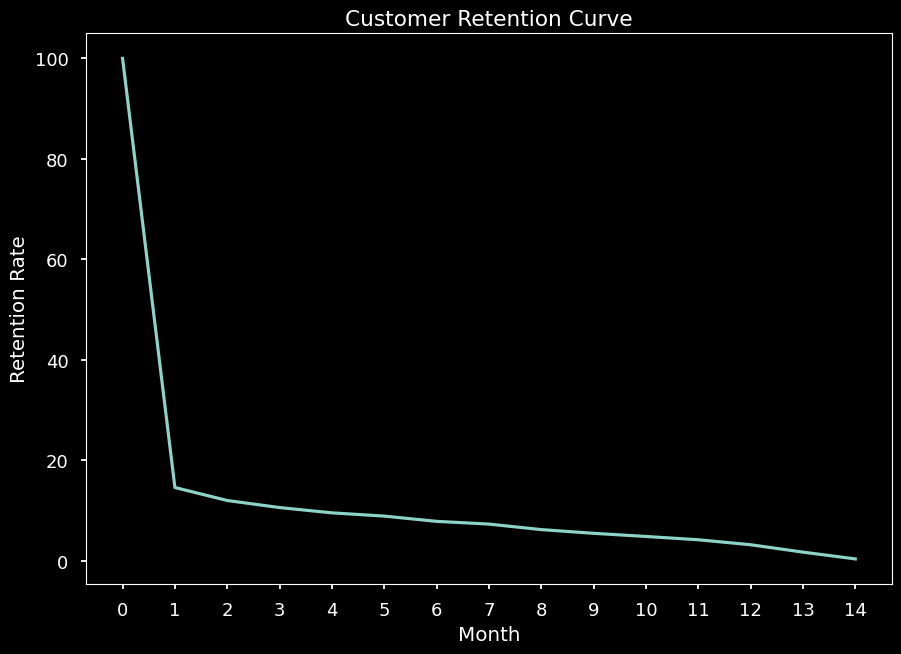

In [27]:
plt.plot(retention_rate.M, retention_rate.RETENTION_RATE)
plt.title("Customer Retention Curve")
plt.ylabel("Retention Rate")
plt.xlabel("Month")
plt.xticks(ticks=retention_rate.M)
plt.show()

#### Inference

- The customer base is **123,208**. These customers are users who have purchased at least once.
- Out of this customer base, the M1 retention rate is **14.59%**. This means that **14.59% of customers (17,973)** return to purchase again one month after their first purchase. Conversely, **more than 80% of customers** do not return to purchase in the first month after their first purchase. Customers **could be encouraged to continue purchasing** after their first purchase, perhaps through discounts for subsequent months, and impproved customer experience.
- The maximum customer lifetime is **14 months**.

## Cohort Analysis

In [12]:
query = """
        SELECT 
                USERID,
                MONTHS_SINCE_FIRST_PURCHASE AS M,
                COHORT_DATE as cohort
        FROM CUSTOMER_COHORT
      """

cohorts_df = pipeline.execute_query(query=query)

cohorts_df = (
    cohorts_df.groupby(["cohort", "M"])[["USERID"]]
    .nunique()
    .assign(
        total=lambda x: x.groupby("cohort")[["USERID"]].transform(lambda x: x.iloc[0]),
        retention=lambda x: 100 * x.USERID / x.total,
    )
    .reset_index()
)

cohorts_df.rename(columns={"USERID": "customer_count"}, inplace=True)

In [13]:
cohorts_df

,cohort,M,customer_count,total,retention
0,2022-09-01,0,4134,4134,100.000000
1,2022-09-01,1,1220,4134,29.511369
2,2022-09-01,2,1090,4134,26.366715
3,2022-09-01,3,849,4134,20.537010
4,2022-09-01,4,898,4134,21.722303
...,...,...,...,...,...
115,2023-09-01,1,903,7502,12.036790
116,2023-09-01,2,474,7502,6.318315
117,2023-10-01,0,7123,7123,100.000000
118,2023-10-01,1,531,7123,7.454724


In [14]:
cohorts_pivot = cohorts_df[["cohort", "M", "retention"]].pivot(
    columns="M", index="cohort"
)["retention"]

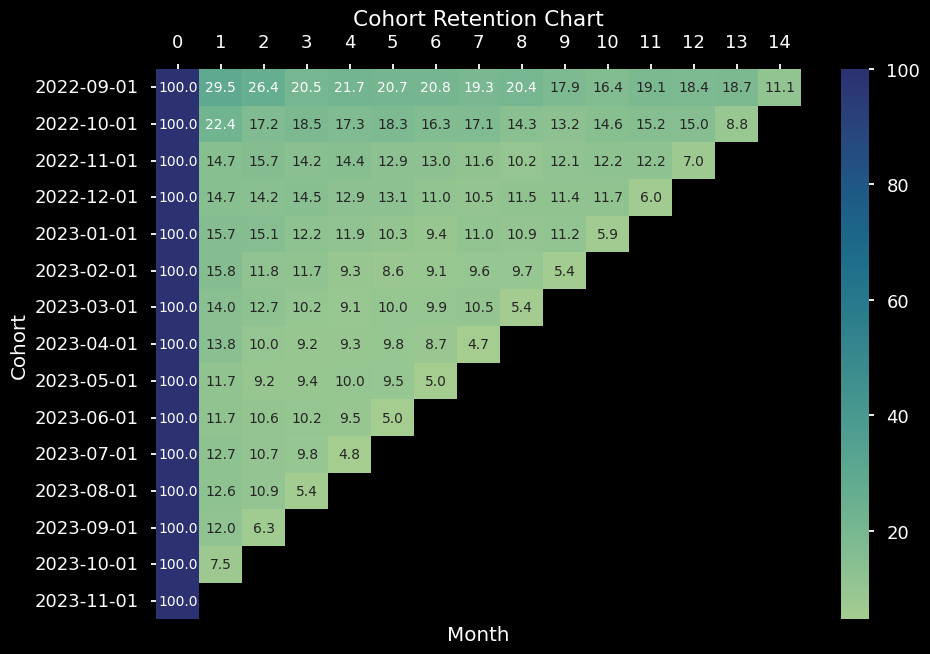

In [25]:
g = sns.heatmap(cohorts_pivot, cmap="crest", annot=True, fmt=".1f")
g.axes.xaxis.set_ticks_position("top")
plt.title("Cohort Retention Chart")
plt.xlabel("Month")
plt.ylabel("Cohort")
plt.show()

#### Inference

- Retention is sustained after M1. It is crucial to reduce the drop after M0 to increase the likelihood of retaining customers for greater revenue.
- The cohort from **September 2022** (2022-09) is the most retained cohort, with retention sustained around **20%** up to M9 (the tenth month).
- There was a drop in retention in **December** for the 2022-09 and 2022-10 cohorts. In December, the 2022-09 cohort dropped by about **6%**, and the 2022-10 cohort dropped by about **3%**.
- There is a noticeable **4-7% drop** in retention during **November** across all cohorts (see diagonal from cohort 2023-10, M1 to cohort 2022-09, M14). What happens in November? The company could consider strategies such as discounted sales or special offers in October, November, and December to sustain or boost retention.
- An increase in retention is observable during the **fall months** (August, September, October). The company could capitalize on this opportunity to boost sales during these months.

## Customer Lifetime Value 

### Read customer lifespan, frequency, sales values

In [30]:
lfs_query = "SELECT * FROM LIFESPAN_FREQUENCY_SALES"
lfs = pipeline.execute_query(query=lfs_query)

Check the data types of columns and converting them appropriately

In [31]:
lfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123210 entries, 0 to 123209
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   userId          123210 non-null  int64  
 1   COHORT_DATE     123210 non-null  object 
 2   purchase_month  123210 non-null  object 
 3   lifespan        123210 non-null  int64  
 4   frequency       123210 non-null  int64  
 5   currency        123210 non-null  object 
 6   average_sales   123210 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 6.6+ MB


In [32]:
def convert_dtypes(data):
    data.rename(columns={"COHORT_DATE": "first_purchase_month"}, inplace=True)
    data["userId"] = data["userId"].astype("object")
    data["purchase_month"] = pd.to_datetime(data["purchase_month"])
    data["first_purchase_month"] = pd.to_datetime(data["first_purchase_month"])
    return data


lfs = convert_dtypes(lfs)

In [33]:
lfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123210 entries, 0 to 123209
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   userId                123210 non-null  object        
 1   first_purchase_month  123210 non-null  datetime64[ns]
 2   purchase_month        123210 non-null  datetime64[ns]
 3   lifespan              123210 non-null  int64         
 4   frequency             123210 non-null  int64         
 5   currency              123210 non-null  object        
 6   average_sales         123210 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 6.6+ MB


### Explore the transaction data 

Convert all **SEK** sales to **Euro** assuming a convertion rate

In [34]:
def sek_euro_converter(values):
    sek_euro_convertion_rate = 0.088
    return (
        values["average_sales"] * sek_euro_convertion_rate
        if values["currency"] == "sek"
        else values["average_sales"]
    )


def convert_currency_and_aggregate(data):
    data["average_sales_euro"] = data.apply(
        sek_euro_converter,
        axis=1,
    )
    data.drop(columns=["currency", "average_sales"], inplace=True)
    data = data.groupby(
        ["userId", "purchase_month", "first_purchase_month"], as_index=False
    ).agg({"lifespan": "mean", "frequency": "sum", "average_sales_euro": "mean"})
    return data


lfs = convert_currency_and_aggregate(lfs)
lfs.head(10)

,userId,purchase_month,first_purchase_month,lifespan,frequency,average_sales_euro
0,65326324392533,2023-05-01,2023-05-01,0.0,1,250.000000
1,168982159910603,2023-08-01,2023-08-01,0.0,1,650.000000
2,219034330643057,2023-11-01,2022-11-01,12.0,3,673.333333
3,271311745575070,2022-12-01,2022-12-01,0.0,1,1180.000000
4,327509841715406,2022-10-01,2022-10-01,0.0,1,1800.000000
5,332400596016082,2023-04-01,2023-04-01,0.0,1,400.000000
6,391633657998574,2022-11-01,2022-11-01,0.0,1,490.000000
7,406087302631582,2023-08-01,2023-08-01,0.0,2,1045.000000
8,472654236140424,2023-11-01,2023-08-01,3.0,2,1025.000000
9,494869758008189,2023-09-01,2023-04-01,5.0,2,688.000000


Check the distributions of lifespan, freqency and average_sales_euros

In [49]:
def show_dist_plot(var_data, title, ylabel, xlabel):
    sns.kdeplot(x=var_data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    # Show the mean, median, mode and max
    plt.axvline(
        x=var_data.mean(),
        color="cyan",
        linestyle="dashed",
        linewidth=2,
        label=f"Mean ({var_data.mean():.2f})",
    )
    plt.axvline(
        x=var_data.median(),
        color="red",
        linestyle="dashed",
        linewidth=2,
        label=f"Median ({var_data.median():.2f})",
    )
    plt.axvline(
        x=var_data.mode()[0],
        color="yellow",
        linestyle="dashed",
        linewidth=2,
        label=f"Mode ({var_data.mode()[0]:.2f})",
    )
    plt.axvline(
        x=var_data.max(),
        color="gray",
        linestyle="dashed",
        linewidth=2,
        label=f"Max ({var_data.max()})",
    )
    plt.axvline(
        x=var_data.min(),
        color="gray",
        linestyle="dashed",
        linewidth=2,
        label=f"Min ({var_data.min()})",
    )
    plt.xlim((var_data.min(), var_data.max()))
    plt.legend()
    plt.show()

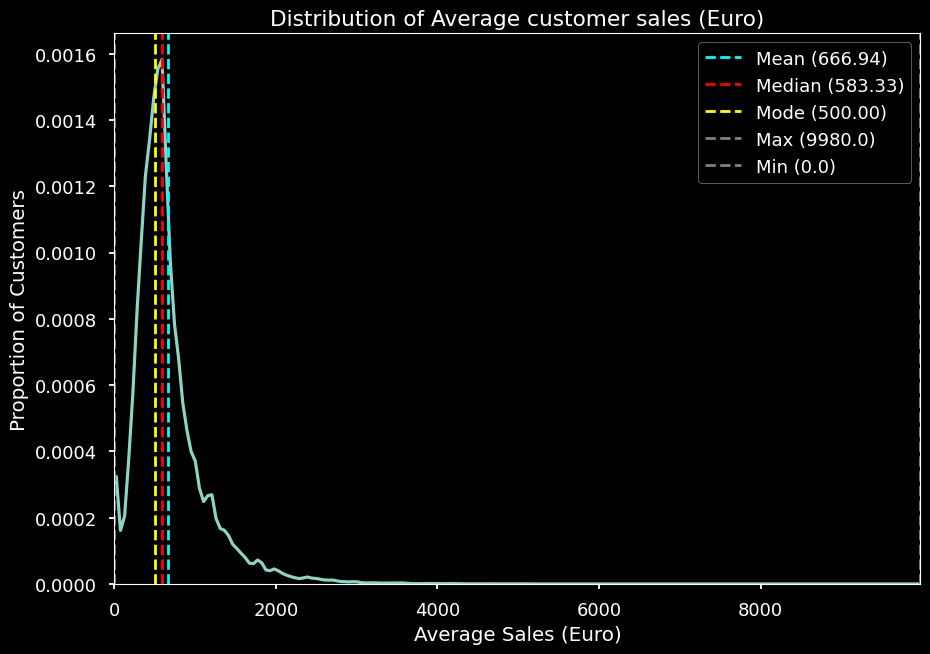

In [50]:
show_dist_plot(
    var_data=lfs["average_sales_euro"],
    title="Distribution of Average customer sales (Euro)",
    ylabel="Proportion of Customers",
    xlabel="Average Sales (Euro)",
)

#### Inference

The distribution of average customer sales is left-skewed. Although the maximum customer sales reach 9,980 euros, the average is 666 euros, with the majority of customers having sales around 500 euros. 

`Question`

The minimum lifetime sales for some customers (4778) is zero. Does this indicate that these orders were free? Customers might have received items through promotions or loyalty programs without direct purchases, leading to zero sales in the data

In [17]:
lfs[lfs["average_sales_euro"] == 0]

,userId,purchase_month,first_purchase_month,lifespan,frequency,average_sales_euro
58,5120141954573712,2022-12-01,2022-12-01,0.0,1,0.0
74,6207944155636470,2023-03-01,2023-03-01,0.0,1,0.0
100,8039853486500445,2023-06-01,2023-05-01,1.0,2,0.0
106,8423360510494468,2023-02-01,2023-02-01,0.0,1,0.0
119,9292090121837218,2022-11-01,2022-11-01,0.0,1,0.0
...,...,...,...,...,...,...
123071,9213804441424331690,2023-07-01,2023-07-01,0.0,2,0.0
123099,9215015255602677840,2022-11-01,2022-11-01,0.0,1,0.0
123130,9217410302401760993,2022-11-01,2022-11-01,0.0,1,0.0
123184,9222211130855761329,2022-11-01,2022-11-01,0.0,1,0.0


In [18]:
pipeline.execute_query(
    """SELECT COUNT(*) AS Zero_Sales_Customers
FROM (
    SELECT userId
    FROM orders
    GROUP BY userId
    HAVING SUM(sales) = 0
) """
)

,Zero_Sales_Customers
0,4778


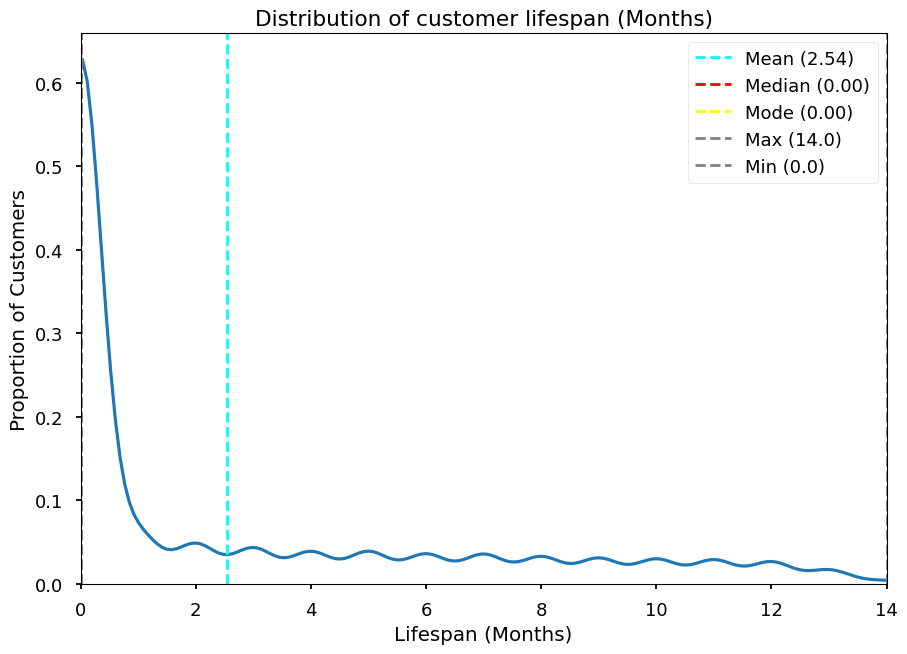

In [19]:
show_dist_plot(
    var_data=lfs["lifespan"],
    xlabel="Lifespan (Months)",
    ylabel="Proportion of Customers",
    title="Distribution of customer lifespan (Months)",
)

#### Inference

Similar to the retention curve, the distribution of customer lifespan is left-skewed. The maximum lifespan is 14 months after the first purchase, with an average of 2.54 months.

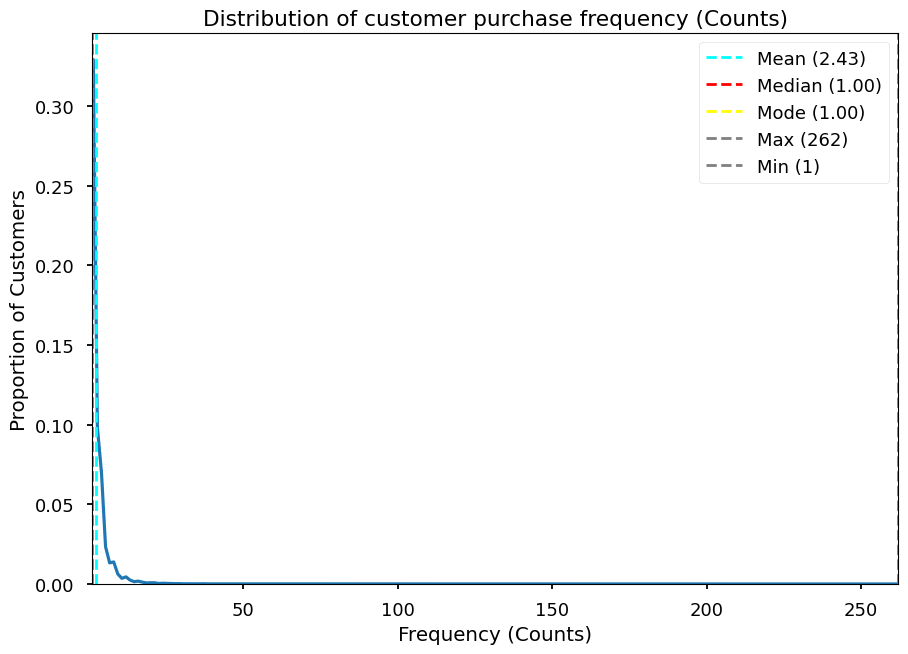

In [20]:
show_dist_plot(
    var_data=lfs["frequency"],
    xlabel="Frequency (Counts)",
    ylabel="Proportion of Customers",
    title="Distribution of customer purchase frequency (Counts)",
)

#### Inference

While most customers make only one purchase, the average purchase frequency is 2.43, with at least one customer having made 250 purchases.

In [21]:
lfs[lfs["frequency"] == 262]

,userId,purchase_month,first_purchase_month,lifespan,frequency,average_sales_euro
5389,402089433377497830,2023-11-01,2022-09-01,14.0,262,567.198473


## Compute Customer Lifetime Value
Compute **CV** as:
$ \text{Average Frequency} \times \text{Average Sales (Euros)}$

Compute **CLV** as:
$ \text{CLV} = \text{Average Lifespan} \times \text{Average Frequency} \times \text{Average Sales (Euros)}$

In [57]:
lfs["CV"] = lfs["frequency"] * lfs["average_sales_euro"]
customer_clv = lfs.copy()

customer_clv.sort_values(by="CV", ascending=False)

,userId,purchase_month,first_purchase_month,lifespan,frequency,average_sales_euro,CV
5389,402089433377497830,2023-11-01,2022-09-01,14.0,262,567.198473,148606.0
91485,6836716632121424733,2023-11-01,2022-09-01,14.0,63,856.031746,53930.0
69095,5156756655607387559,2023-10-01,2022-09-01,13.0,34,1555.588235,52890.0
77438,5786196591665482994,2023-10-01,2022-09-01,13.0,76,668.421053,50800.0
26437,1963435673590959229,2023-11-01,2022-10-01,13.0,39,1171.794872,45700.0
...,...,...,...,...,...,...,...
41087,3052559157775286154,2022-11-01,2022-11-01,0.0,1,0.000000,0.0
80374,6002307372811900218,2022-11-01,2022-11-01,0.0,1,0.000000,0.0
41114,3055220048359771058,2022-10-01,2022-10-01,0.0,1,0.000000,0.0
80370,6002096817342340296,2023-09-01,2023-09-01,0.0,1,0.000000,0.0


In [58]:
CLV = (
    customer_clv["lifespan"].mean()
    * customer_clv["frequency"].mean()
    * customer_clv["average_sales_euro"].mean()
)

CLV

4130.549767444847

Assuming a profit margin

In [24]:
profit_margin = 0.05
CLV * profit_margin

206.52748837224237

## `Now answering the Marketing question`

### Inference

- The average customer generates **4,130 euros** in sales.
- Assuming a profit margin of **5%**, the profit from an average customer is **206.53 euros**. Therefore, the marketing team should not spend more than **206.53 euros** to acquire a new customer.

## Using probabilistic models to estimate future CLV

Given the skewness in customer lifespan, purchase frequency, and average sales, and the fact that the CLV formula uses averages, on historical data, this CLV estimate may not be entirely reliable when looking into the future. Unlike subscription-based models, where retention is more predictable, customers in this case can leave and return at any time. There is the need to explore more advanced methods that leverage customer behavior trends and enable more confident estimation of Customer Lifetime Values (CLVs). This [video](https://www.youtube.com/watch?v=guj2gVEEx4s&ab_channel=FirstMarkCapital) emphasizes the importance of probabilistic modeling for customer behavior in non-subscription-based businesses. 


The [lifetimes](https://lifetimes.readthedocs.io/en/latest/index.html) marketing science python libraries will be used in these probalistic estimations. We use the **BetaGeoFitter** and **GammaGammaFitter** models in lifetimes package.

### Computing T (Age of Customer)
`T` is the age of customers at the end of the period under study. So in our data, this is the age of the customer in months from first purchase date and the last transation dataset

In [59]:
trans_data = lfs.copy()
period_end_date = trans_data["purchase_month"].max()

trans_data["T"] = trans_data["first_purchase_month"].apply(
    lambda x: (period_end_date.to_period("M") - x.to_period("M")).n
)
trans_data = trans_data[
    ["userId", "frequency", "lifespan", "T", "average_sales_euro", "CV"]
]

### Predicting future purchases and probability that the customer is alive

The model requires repeat customers only, i.e, customer who purchased again after their first transaction


In [60]:
trans_data = trans_data[trans_data.lifespan > 0]
trans_data.set_index("userId")

,frequency,lifespan,T,average_sales_euro,CV
userId,,,,,
219034330643057,3,12.0,12,673.333333,2020.0
472654236140424,2,3.0,3,1025.000000,2050.0
494869758008189,2,5.0,7,688.000000,1376.0
857319303011182,5,13.0,13,556.000000,2780.0
1010263118317948,2,4.0,4,850.000000,1700.0
...,...,...,...,...,...
9223090445069821952,6,8.0,13,983.333333,5900.0
9223097207332177627,2,2.0,8,470.000000,940.0
9223113765943846674,4,4.0,11,500.000000,2000.0


In [166]:
from lifetimes import BetaGeoFitter
from lifetimes.plotting import (
    plot_frequency_recency_matrix,
    plot_probability_alive_matrix,
    plot_period_transactions,
)

# penalizer_coef hyperparameter tunning
def best_penalizer_coef(min_r=0.9):
    param_space = np.linspace(0.001, 1)
    r2_values = pd.DataFrame()
    for p in param_space:
        beta_geo = BetaGeoFitter(penalizer_coef=p)
        beta_geo.fit(
            frequency=trans_data["frequency"],
            recency=trans_data["lifespan"],
            T=trans_data["T"],
        )
        r = beta_geo.summary.loc["r", "coef"]
        print(f"penalizer_coef {p}, r {r}")
        r2_values = pd.concat(
            [r2_values, pd.DataFrame({"penalizer_coef": [p], "r": [r]})], ignore_index=True
        )

        if r<=min_r:
            break

    r2_values.set_index("penalizer_coef", inplace=True)
    return [r2_values.idxmin().values[0] , r2_values]


In [167]:
penalizer_coef, result = best_penalizer_coef(min_r=0.7)

penalizer_coef 0.001, r 3.32099113597663
penalizer_coef 0.021387755102040818, r 1.799377213497318
penalizer_coef 0.041775510204081635, r 1.475567229727938
penalizer_coef 0.062163265306122456, r 1.301089174744519
penalizer_coef 0.08255102040816327, r 1.1853888497715033
penalizer_coef 0.10293877551020408, r 1.1005488272308692
penalizer_coef 0.12332653061224491, r 1.0344773987823646
penalizer_coef 0.1437142857142857, r 0.9809073147223525
penalizer_coef 0.16410204081632654, r 0.9361984785410343
penalizer_coef 0.18448979591836737, r 0.8980620649053187
penalizer_coef 0.20487755102040817, r 0.8649727473788379
penalizer_coef 0.225265306122449, r 0.8358660325521727
penalizer_coef 0.24565306122448982, r 0.8099730116146143
penalizer_coef 0.26604081632653065, r 0.7867205746351674
penalizer_coef 0.2864285714285714, r 0.7656718113062092
penalizer_coef 0.30681632653061225, r 0.7464863593435774
penalizer_coef 0.3272040816326531, r 0.7288944038121647
penalizer_coef 0.3475918367346939, r 0.7126787448343

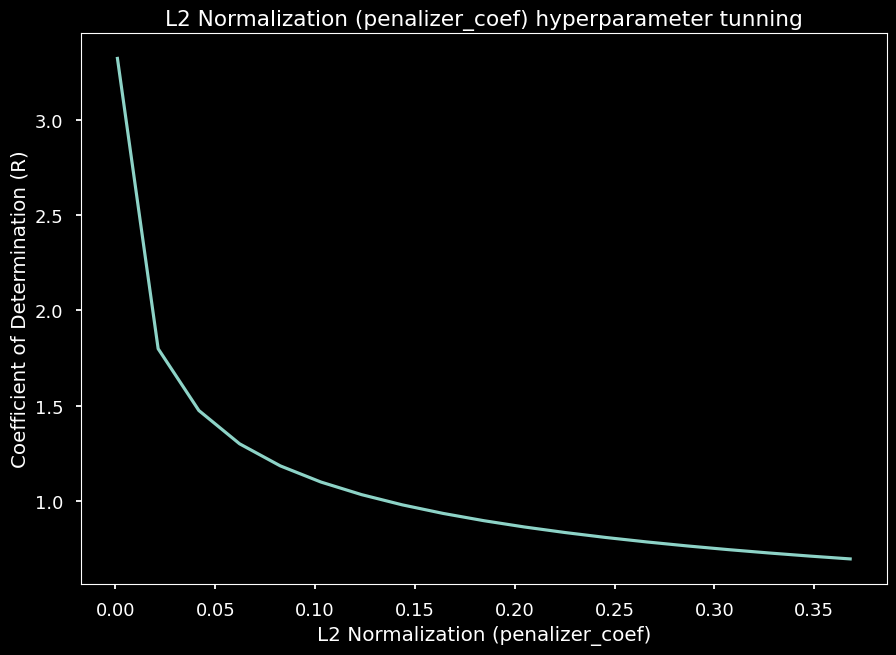

In [168]:
plt.plot(result.index, result["r"])
plt.title("L2 Normalization (penalizer_coef) hyperparameter tunning")
plt.xlabel("L2 Normalization (penalizer_coef)")
plt.ylabel("Coefficient of Determination (R)")
plt.show()

In [169]:
penalizer_coef

0.36797959183673473

In [170]:

bgf = BetaGeoFitter(penalizer_coef=penalizer_coef)
bgf.fit(
    frequency=trans_data["frequency"], recency=trans_data["lifespan"], T=trans_data["T"]
)
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.697662,0.003119,0.691549,0.703775
alpha,1.040423,0.008289,1.024177,1.056668
a,0.064063,0.001160,0.061790,0.066337
b,0.390233,0.003604,0.383170,0.397296


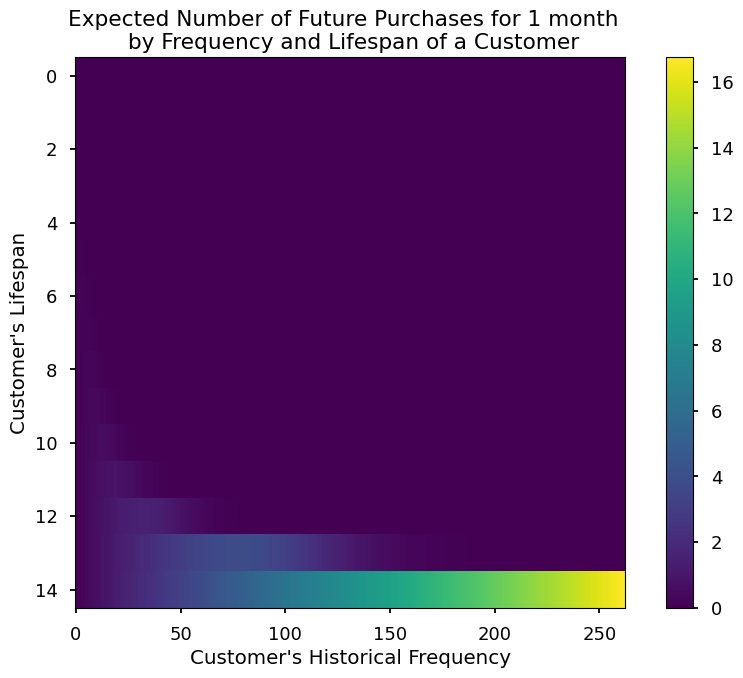

In [28]:
time_unit = 1
plot_frequency_recency_matrix(bgf, T=time_unit)
plt.title(
    f"Expected Number of Future Purchases for {time_unit} month  \n by Frequency and Lifespan of a Customer"
)
plt.ylabel("Customer's Lifespan")
plt.show()

#### Inference

* Customers who made 100 or more purchases by their 14th month with the company are likely to make 8 to 16 purchases in the following month. 

* Customers who made 25 to 100 purchases recently (between months 10 and 13) are likely to make 2 to 5 purchases next month. However, we do not know the probability that these customers will be alive (with next month). 

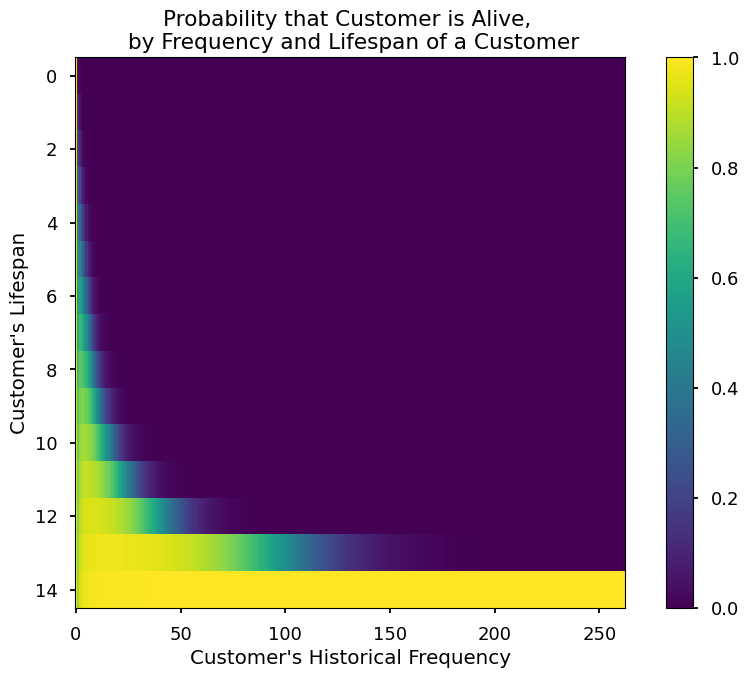

In [29]:
plot_probability_alive_matrix(bgf)
plt.title(
    f"Probability that Customer is Alive, \n by Frequency and Lifespan of a Customer"
)
plt.ylabel("Customer's Lifespan")
plt.show()

In [30]:
trans_data["predict_purchases_next_1_m"] = (
    bgf.conditional_expected_number_of_purchases_up_to_time(
        t=time_unit,
        frequency=trans_data["frequency"],
        recency=trans_data["lifespan"],
        T=trans_data["T"],
    )
)
trans_data["predict_probability_alive"] = bgf.conditional_probability_alive(
    frequency=trans_data["frequency"], recency=trans_data["lifespan"], T=trans_data["T"]
)
trans_data.sort_values(by="predict_purchases_next_1_m", ascending=False).head(10)

,userId,frequency,lifespan,T,average_sales_euro,CV,predict_purchases_next_1_m,predict_probability_alive
5389,402089433377497830,262,14.0,14,567.198473,148606.0,16.743371,0.999504
6718,497424748271724727,95,13.0,13,333.789474,31710.0,6.526133,0.998632
53342,3959435739687960670,72,11.0,11,623.333333,44880.0,5.743214,0.998194
5963,444730773991424385,54,9.0,9,352.962963,19060.0,5.134769,0.997590
45773,3405990330003900548,17,2.0,2,191.176471,3250.0,4.848680,0.992298
31378,2333573918598501663,70,13.0,13,467.785714,32745.0,4.826127,0.998142
74554,5569149071209566419,65,13.0,13,331.153846,21525.0,4.486122,0.997999
122945,9204248135457745700,65,13.0,13,389.384615,25310.0,4.486122,0.997999
103802,7763147301647778346,47,9.0,9,473.829787,22270.0,4.480870,0.997230
55732,4144786482233488865,68,14.0,14,227.500000,15470.0,4.391507,0.998087


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

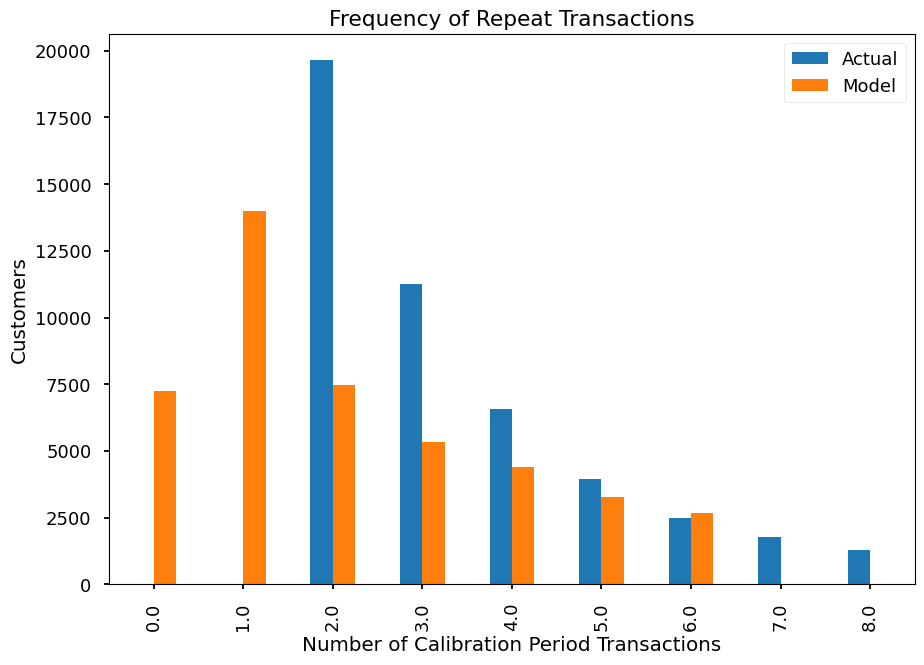

In [31]:
plot_period_transactions(bgf)

### Predicting future sales of customer for CLV
The model assumes that
*  Customer are repeat customers only, i.e, customer who purchased again after their first transaction
* The frequency and average_sales_euro are not (strongly) correlated,  
* All monetary values are greater than zero

In [32]:
trans_data = trans_data[trans_data["average_sales_euro"] > 0]
trans_data.set_index("userId")
trans_data[["frequency", "average_sales_euro"]].corr()

,frequency,average_sales_euro
frequency,1.000000,-0.081475
average_sales_euro,-0.081475,1.000000


In [33]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(trans_data["frequency"], trans_data["average_sales_euro"])

bgf.fit(
    frequency=trans_data["frequency"], recency=trans_data["lifespan"], T=trans_data["T"]
)

<lifetimes.BetaGeoFitter: fitted with 51409 subjects, a: 0.13, alpha: 1.64, b: 0.72, r: 1.11>

In [34]:
look_forward_months = 6
trans_data["predicted_CLV"] = ggf.customer_lifetime_value(
    bgf,  # the model to use to predict the number of future transactions
    trans_data["frequency"],
    trans_data["lifespan"],
    trans_data["T"],
    trans_data["average_sales_euro"],
    time=look_forward_months,
    discount_rate=0.0,
    freq="M",
)
predicted_CLV = trans_data["predicted_CLV"].mean()

In [35]:
print(
    f"Starting from {period_end_date.strftime('%Y-%m-%d')}, the predicted CLV for {look_forward_months} months is {predicted_CLV:.2f} euros"
)
print(
    f"Assuming a profit margin of {profit_margin*100} percent, the profit from an average customer is {predicted_CLV*profit_margin:.2f} euros. \nTherefore, the marketing team should not spend more than {predicted_CLV*profit_margin:.2f} to acquire a new customer within the next {look_forward_months} months."
)

Starting from 2023-11-01, the predicted CLV for 6 months is 1417.62 euros
Assuming a profit margin of 5.0 percent, the profit from an average customer is 70.88 euros. 
Therefore, the marketing team should not spend more than 70.88 to acquire a new customer within the next 6 months.


## `More answers for the Marketing question`

The marketing team can predict the CLV for the entire customer base over a given time frame. Starting from 2023-11-01, the predicted CLV for the next 6 months is 1,417.62 euros. Assuming a profit margin of 5%, the expected profit from an average customer is 70.88 euros. Therefore, the marketing team should not spend more than 70.88 euros to acquire a new customer over the next 6 months.

While probabilistic models may provide more accurate CLV calculations, they can still be fine-tuned using cross-validation, as explained in the [Lifetimes model guide](https://lifetimes.readthedocs.io/en/latest/Quickstart.html#more-model-fitting).

## Using Machine Learning

The marketing team now has a good understanding of both historical and future CLV. The next step is to analyze customer behaviors that may influence CLV. How much will customers purchase in the future, and what is the probability that they will continue to buy? With machine learning predictive analysis, the marketing team can predict the CLV of new customer who starts purchasing from the company. Additionally, identifying the top customers for the next prediction window allows the marketting team to target them strategically to boost sales.  

### Load and transform data 

To predict future customer behavior, transactions from any time before the past 90 days will be used to engineer features, while transactions within the last 90 days will be used to engineer targets.

In [159]:
last_trans_date = pd.to_datetime(
    pipeline.execute_query(
        "SELECT MAX(DATE(CREATEDAT)) LAST_TRANS_DATE FROM ORDERS"
    ).loc[0, "LAST_TRANS_DATE"]
)
cut_off_90_date = last_trans_date - pd.to_timedelta(90, unit="d")

The queries below are similar to `LIFESPAN_FREQUENCY_SALES` View in the database. However, SQLite does not support parameters in views or provide native support for stored procedures.

In [160]:
past_transations_query = """
    WITH FIRSTORDERDATES AS (
            SELECT 
                USERID, 
                strftime('%Y-%m-01', MIN(DATE(CREATEDAT)))  AS COHORT_DATE
            FROM ORDERS
            GROUP BY USERID
        )

    SELECT 
        O.USERID,
        FOD.COHORT_DATE,
        strftime('%Y-%m-01', MAX(DATE(CREATEDAT)))  AS purchase_month,
        ((strftime('%Y', MAX(DATE(CREATEDAT))) - strftime('%Y', FOD.COHORT_DATE)) * 12) + (strftime('%m', MAX(DATE(CREATEDAT))) - strftime('%m', FOD.COHORT_DATE)) as lifespan,
        COUNT(O.SALES) AS frequency,
        O.currency,
        AVG(O.SALES) AS average_sales
    FROM ORDERS O
    LEFT JOIN FIRSTORDERDATES FOD ON O.USERID = FOD.USERID
    WHERE O.CREATEDAT<?
    GROUP BY O.USERID, O.currency
"""
past_ml_data = pipeline.execute_query(
    query=past_transations_query, param=(cut_off_90_date.strftime("%Y-%m-%d"),)
)

In [161]:
future_transations_query = """
    WITH FIRSTORDERDATES AS (
            SELECT 
                USERID, 
                strftime('%Y-%m-01', MIN(DATE(CREATEDAT)))  AS COHORT_DATE
            FROM ORDERS
            GROUP BY USERID
        )

    SELECT 
        O.USERID,
        FOD.COHORT_DATE,
        strftime('%Y-%m-01', MAX(DATE(CREATEDAT)))  AS purchase_month,
        ((strftime('%Y', MAX(DATE(CREATEDAT))) - strftime('%Y', FOD.COHORT_DATE)) * 12) + (strftime('%m', MAX(DATE(CREATEDAT))) - strftime('%m', FOD.COHORT_DATE)) as lifespan,
        COUNT(O.SALES) AS frequency,
        O.currency,
        AVG(O.SALES) AS average_sales
    FROM ORDERS O
    LEFT JOIN FIRSTORDERDATES FOD ON O.USERID = FOD.USERID
    WHERE O.CREATEDAT>=?
    GROUP BY O.USERID, O.currency
"""
future_ml_data = pipeline.execute_query(
    query=future_transations_query, param=(cut_off_90_date.strftime("%Y-%m-%d"),)
)

Convert purchases in SEK to EURO assuming a conversion rate

In [162]:
past_ml_data = convert_dtypes(past_ml_data)
past_ml_data = convert_currency_and_aggregate(past_ml_data)
past_ml_data.set_index("userId", inplace=True)

future_ml_data = convert_dtypes(future_ml_data)
future_ml_data = convert_currency_and_aggregate(future_ml_data)
future_ml_data.set_index("userId", inplace=True)

### Feature engineering

**`Age`** is the number of months that have elapsed since the customer's first purchase.

In [163]:
past_ml_data["customer_age"] = past_ml_data["first_purchase_month"].apply(
    lambda x: (last_trans_date.to_period("M") - x.to_period("M")).n
)

**`Total sales`** is the sum of the sales of the customer, computed as $ \text{Frequency} \times \text{Average Sales (Euros)}$

In [164]:
past_ml_data["total_sales"] = (
    past_ml_data["frequency"] * past_ml_data["average_sales_euro"]
)

**`Recency`** indicates how recent (in months) the customer's last purchase is. The most recent purchases have a recency of zero, while older transactions have negative recency values.

In [165]:
past_ml_data["recency"] = past_ml_data["purchase_month"].apply(
    lambda x: (x.to_period("M") - last_trans_date.to_period("M")).n
)

**`sales_2weeks_avg`** is the average sales from a customer's transactions within the last two weeks.  

**`transaction_2weeks_count`** indicates the number of customer's transactions that occurred within the last two weeks.

In [166]:
cut_off_2weeks_date = past_ml_data["purchase_month"].max() - pd.to_timedelta(
    14, unit="d"
)

sales_2weeks_features = (
    past_ml_data[past_ml_data["purchase_month"] >= cut_off_2weeks_date]
    .groupby(["userId"])
    .agg(
        sales_2weeks_avg=("average_sales_euro", "mean"),
        transaction_2weeks_count=("average_sales_euro", "count"),
    )
)

past_ml_data = past_ml_data.merge(
    sales_2weeks_features, left_index=True, right_index=True, how="left"
).fillna(0)

**Targets**

**`sales_next_90_avg`** is the average sales of a customer in the next 90 days. 
 
**`sales_next_90_flag`** indicates whether the customer is will make purchases in the next 90 days.

In [167]:
sales_next_90_features = (
    future_ml_data.groupby(["userId"])
    .agg(sales_next_90_avg=("average_sales_euro", "mean"))
    .assign(sales_next_90_flag=1)
)


ml_df = past_ml_data.merge(
    sales_next_90_features, left_index=True, right_index=True, how="left"
).fillna(0)

Correlation between all features and targets

<Axes: >

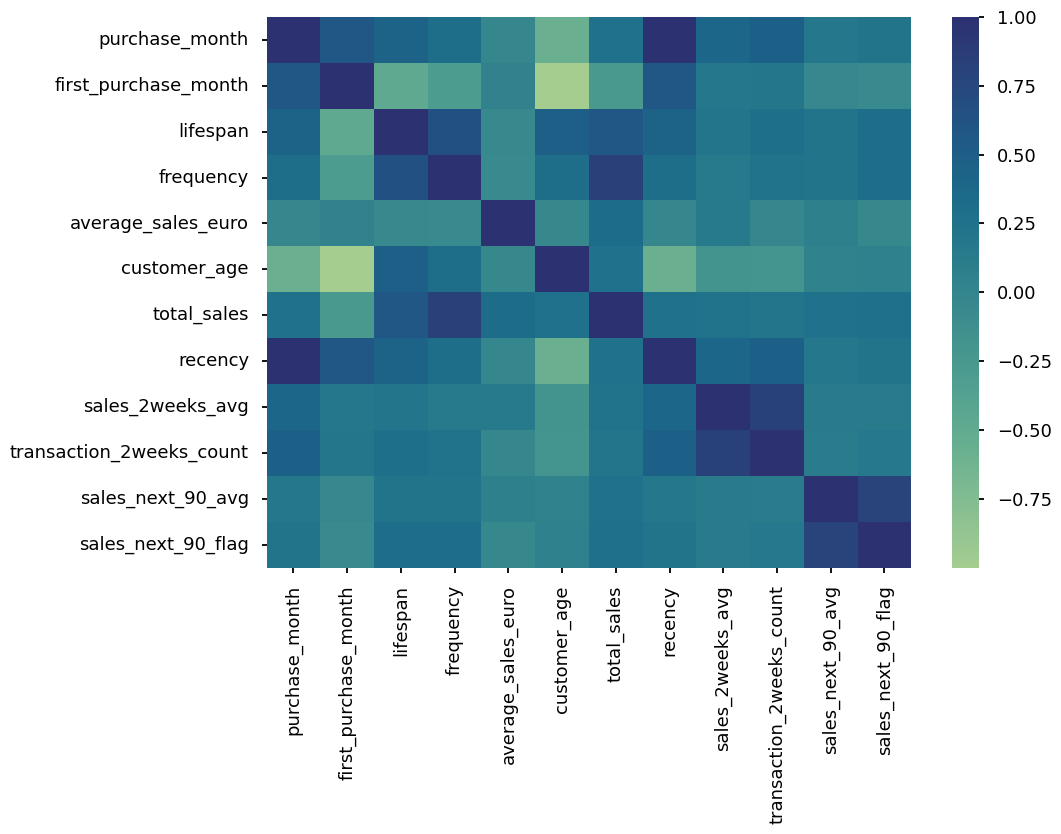

In [168]:
sns.heatmap(ml_df.corr(), cmap="crest")

In [169]:
features = ml_df[
    [
        "frequency",
        "average_sales_euro",
        "customer_age",
        "recency",
        "sales_2weeks_avg",
        "transaction_2weeks_count",
    ]
]
reg_target = ml_df["sales_next_90_avg"]
class_target = ml_df["sales_next_90_flag"]

### Regression and Classification modeling

In [171]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV

In [173]:
regressor = XGBRegressor()
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001],
    "subsample": [0.5, 0.7, 1],
    "n_estimators": [50, 100, 1000],
}

grid_search_reg = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=KFold(n_splits=10),
    scoring="neg_mean_absolute_error",
)

grid_search_reg.fit(X=features, y=reg_target)
# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search_reg.best_params_)
print(f"Best Mean MAE:{np.absolute(grid_search_reg.best_score_):.3f}")

Best set of hyperparameters:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.7}
Best Mean MAE:216.799


In [174]:
pred_sale_next_90_avg = grid_search_reg.best_estimator_.predict(features)

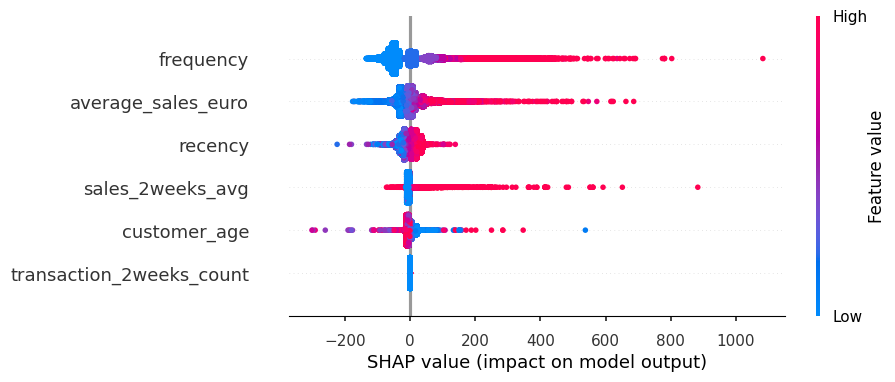

In [175]:
import shap

explainer_reg = shap.TreeExplainer(grid_search_reg.best_estimator_)
explanation_reg = explainer_reg(features)
shap_values_reg = explanation_reg.values
shap.plots.beeswarm(explanation_reg)

#### Inference

* The regression model can predict the average sales for the next 90 days with a margin of plus or minus 200 euros.
* The predicted average sales next 90 days is impacted by Frequency of puchase, average sales in the past, and recency of the purchase. More frequent buyers are with higher averages sales in the past and more recent transactions are expected to contribute to higher average sales in the next 90 days.
* Customer age and transactions in the last two weeks do not show a clear relationship with their average sales in the next 90 days.

In [177]:
classifier = XGBClassifier()

grid_search_cls = GridSearchCV(
    estimator=classifier,
    param_grid=param_grid,
    cv=KFold(n_splits=10),
    scoring="roc_auc",
)

grid_search_cls.fit(X=features, y=class_target)
# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search_cls.best_params_)
print(f"Best AUC:{np.absolute(grid_search_cls.best_score_)*100:.2f}")

Best set of hyperparameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}
Best AUC:71.97


In [178]:
pred_proba_sale_next_90 = grid_search_cls.best_estimator_.predict_proba(features)[:, 1]
pred_sale_next_90_flag = grid_search_cls.best_estimator_.predict(features)

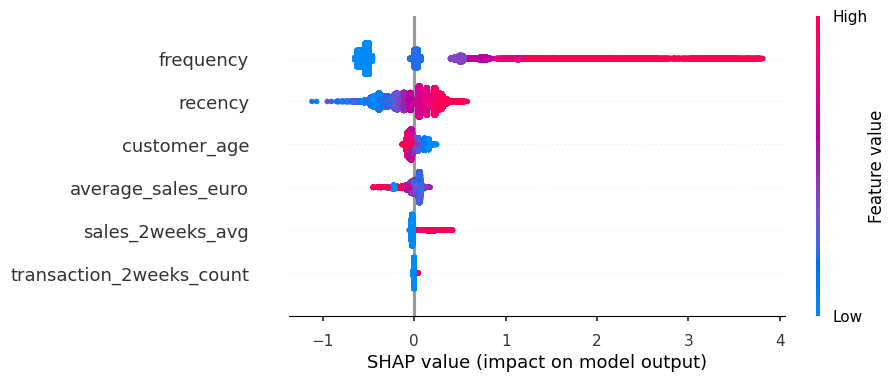

In [179]:
explainer_cls = shap.TreeExplainer(grid_search_cls.best_estimator_)
explanation_cls = explainer_cls(features)
shap_values_cls = explanation_cls.values
shap.plots.beeswarm(explanation_cls)

#### Inference

* The model can predict the probability of a customer purchasing in the next 90 days with high accuracy ( AUC of 71.97 %)
* Frequency, recency of transactions, and customer age influence the probability of a customer making a purchase in the next 90 days.
* Older customers who have not purchased recently or have made fewer purchases in the past are less likely to make a purchase in the next 90 days. Conversely, newer customers with a high frequency of purchases and more recent transactions are more likely to make a purchase in the next 90 days.

In [187]:
# merge predictions into features
final_table = features.copy()
final_table["pred_sale_next_90_avg"] = pred_sale_next_90_avg
final_table["pred_proba_sale_next_90"] = pred_proba_sale_next_90
final_table.sort_values(by=["pred_sale_next_90_avg"], ascending=False, inplace=True)

## `More answers for the Marketing team`

#### Top customers with the high probability of purchase in the next 90 days

In [191]:
## Top customers with the high probability of purchase in the next 90 days
top_n = 50
prob_threshold = 0.5
sale_threshold = 0.0
final_table = final_table[
    (final_table["pred_proba_sale_next_90"] >= prob_threshold)
    & (final_table["pred_sale_next_90_avg"] > sale_threshold)
]

In [196]:
top_n_customers = final_table.head(top_n)
top_n_customers

,frequency,average_sales_euro,customer_age,recency,sales_2weeks_avg,transaction_2weeks_count,pred_sale_next_90_avg,pred_proba_sale_next_90
userId,,,,,,,,
6466311134798860530,8,1255.625000,11,-3,1255.625000,1.0,2609.890869,0.707868
5751267705453534770,7,2265.714286,13,-3,2265.714286,1.0,2186.032959,0.766092
7301457211102063352,8,1632.500000,13,-3,1632.500000,1.0,1779.968140,0.761263
3413727104991269184,18,1501.666667,10,-3,1501.666667,1.0,1729.994873,0.958234
8947766884244807627,5,1853.400000,12,-3,1853.400000,1.0,1652.913696,0.620687
6637608848075134823,6,2199.833333,12,-6,0.000000,0.0,1609.187256,0.512924
5794839213058583147,13,1246.215385,13,-5,0.000000,0.0,1550.748901,0.821302
7803134376982934048,7,2128.571429,10,-6,0.000000,0.0,1481.502686,0.601594
7308564510325687140,8,1621.250000,13,-3,1621.250000,1.0,1463.014648,0.771856


In [209]:
print(f"The top {top_n} customers can generate {top_n_customers["pred_sale_next_90_avg"].mean()*top_n:.2f} in average sales with between {top_n_customers["pred_proba_sale_next_90"].min()*100:.2f} and {top_n_customers["pred_proba_sale_next_90"].max()*100:.2f} percent probability for the company")

The top 50 customers can generate 62049.34 in average sales with between 51.29 and 96.99 percent probability for the company


#### Inference

The top 50 customers can generate an average of 62,049.34 euros in sales, with a probability ranging from 51.29% to 96.99% for the company. Targetting these to customers for more frequent and recent purchases will achieve even higher sales. 